In [1]:
# Importing the required libraries:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os
import cv2
import skimage

import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline 

# Ignore harmless warnings:

import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import platform
print(torch.__version__)
print(platform.python_version())

1.1.0
3.6.10


In [2]:
torch.cuda.get_device_name(0)

'TITAN X (Pascal)'

In [3]:
train_set = ['hola', 'urjc', 'gavab', 'estoril', 'alvaro', 'victoria'] * 512
import random
random.seed(123)
random.shuffle(train_set)

val_set = ['hola', 'urjc', 'gavab', 'estoril', 'alvaro', 'victoria'] * 32

len_train = len(train_set)
len_val = len(val_set)

In [4]:
# Function to convert letters (and therefore words) into PyTorch tensors:

letters = ['SOS_token', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k',
          'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'EOS_token']

def letter_to_vector(letter):
    vector = torch.zeros(1, 1, len(letters))
    for i in range(len(letters)):
        if letters[i] == letter:
            vector[0, 0, i] = 1.
    return(vector)

print(letter_to_vector('SOS_token'))

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])


In [5]:
# Defining model and architecture:

# CONVOLUTIONAL NEURAL NETWORK:

class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1, 2) # padding???
        self.conv2 = nn.Conv2d(20, 50, 5, 1, 2)
        self.fc1 = nn.Linear(12*2*50, 1024)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 12*2*50) # -1 para no tener que determinar aquí el tamaño del batch (se ajusta, podemos variarlo)
        X = F.relu(self.fc1(X))

        return X 

In [6]:
# ENCODER:

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        #self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(input_size, hidden_size)

    def forward(self, input, hidden):
        #embedded = self.embedding(input).view(1, 1, -1)
        output = input.view(1,1,-1)
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [7]:
# DECODER:

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        #self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(output_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = input.view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [17]:
# Instantiate the model, define loss and optimization functions:

torch.manual_seed(123)

input_size = 1024
hidden_size = 256
output_size = 28

CNN_model = ConvolutionalNetwork().cuda()
CNN_optimizer = torch.optim.Adam(CNN_model.parameters(), lr = 0.001)

Encoder_model = EncoderRNN(input_size = input_size, hidden_size = hidden_size).cuda()
Encoder_optimizer = optim.SGD(Encoder_model.parameters(), lr = 0.001)

Decoder_model = DecoderRNN(hidden_size = hidden_size, output_size = output_size).cuda()
Decoder_optimizer = optim.SGD(Decoder_model.parameters(), lr = 0.001)

#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()

In [23]:
# TRAINING THE MODEL:

import time
start_time = time.time()

# Setting the image parameters:

height = 48
width = 192

# Setting the sliding window parameters:

patch_height = 48
patch_width = 10
stepsize = 2
n_patches = int((width - patch_width)/stepsize + 1)

# Setting the sliding window parameters:

torch.manual_seed(123)
epochs = 30
train_losses = []
val_losses = []

for i in range(epochs):
    
    for j in range(len_train): # we chose individual words/images as batches:
        
        CNN_optimizer.zero_grad()
        Encoder_optimizer.zero_grad()
        Decoder_optimizer.zero_grad()
        
        image = 255 * np.ones(shape = [height, width], dtype = np.uint8)
        image = cv2.putText(image, text = train_set[j], org = (5, 30),
        fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.7, color = (0, 0, 0),
        thickness = 2, lineType = cv2.LINE_AA)
        
        image = transforms.ToPILImage()(image) # np.ndarray to PIL.Image.Image
        
        input_word = list(train_set[j])
        input_word_length = len(input_word) # number of letters
        encoder_hidden = Encoder_model.initHidden()
        
        
        for p in range(n_patches):
            
            patch = transforms.functional.crop(image, 0, 0 + p * stepsize, patch_height, patch_width) # cropping of the image into patches
            patch = transforms.ToTensor()(patch) # torch.Tensor of the patch (normalized)
            #patch = skimage.util.random_noise(patch, mode='gaussian') # we set some random noise to the image
            #patch = torch.from_numpy(patch) # conversion to pytorch tensor again
            patch = 1. - patch # it will work better if we have white text over black background
            patch = patch.view(1, 1, 48, 10) # CNN_model expects a 4-dimensional tensor (1 dimension for batch)
            patch = patch.type(torch.FloatTensor) # conversion to float
            patch = patch.cuda() # set to cuda

            encoder_input = CNN_model(patch).cuda() # 1024-length vector associated to patch p (i.e. CNN output, Encoder input)
            
            _, encoder_hidden = Encoder_model(encoder_input, encoder_hidden)
            
        decoder_input = letter_to_vector('SOS_token').cuda()
        decoder_hidden = encoder_hidden
                
        
        for d in range(input_word_length):
            
            decoder_output, decoder_hidden = Decoder_model(decoder_input, decoder_hidden)
            #decoder_input = letter_to_vector(input_word[d]) # teacher forcing
            
            one_hot_decoder_output = torch.zeros(1, 1, output_size).cuda()
            one_hot_decoder_output[0][0][torch.argmax(decoder_output)] = 1.
            decoder_input = one_hot_decoder_output.cuda()
            
            if torch.equal(one_hot_decoder_output, letter_to_vector('EOS_token').cuda()) == True:
                break
            
            if d == 0:
                
                output_word = decoder_output 
                one_hot_input_letter = letter_to_vector(input_word[d]).type(torch.LongTensor)
                one_hot_input_word = one_hot_input_letter
                index = torch.argmax(one_hot_input_letter.view(output_size))
                ground_letter = torch.tensor([index], dtype = torch.long)
                ground_word = ground_letter
                
            else:
                
                output_word = torch.cat((output_word, decoder_output), dim = 0) # we concatenate the remaining output letters
                one_hot_input_letter = letter_to_vector(input_word[d]).type(torch.LongTensor)
                one_hot_input_word = torch.cat((one_hot_input_word, one_hot_input_letter), dim = 0)
                index = torch.argmax(one_hot_input_letter.view(output_size))
                ground_letter = torch.tensor([index], dtype = torch.long)
                ground_word = torch.cat((ground_word, ground_letter), dim = 0)

                
        one_hot_input_word = one_hot_input_word.view(-1, output_size)
        output_word = output_word.view(-1, output_size) 
        ground_word = ground_word.cuda()
        loss = criterion(output_word, ground_word)
        
        loss.backward()
        
        CNN_optimizer.step()
        Encoder_optimizer.step()
        Decoder_optimizer.step()
        
    train_losses.append(loss)
    
    # VALIDATION SET:
    
    with torch.no_grad():
        
        for j in range(len_val): # we chose individual words/images as batches:
        
            image_val = 255 * np.ones(shape = [height, width], dtype = np.uint8)
            image_val = cv2.putText(image_val, text = val_set[j], org = (5, 30),
            fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.7, color = (0, 0, 0),
            thickness = 2, lineType = cv2.LINE_AA)

            image_val = transforms.ToPILImage()(image_val) # np.ndarray to PIL.Image.Image

            input_word_val = list(val_set[j])
            input_word_val_length = len(input_word_val) # number of letters

            encoder_hidden_val = Encoder_model.initHidden()
        
        
            for p in range(n_patches):

                patch_val = transforms.functional.crop(image_val, 0, 0 + p * stepsize, patch_height, patch_width) # cropping of the image into patches
                patch_val = transforms.ToTensor()(patch_val) # torch.Tensor of the patch (normalized)
                #patch_val = skimage.util.random_noise(patch_val, mode='gaussian') # we set some random noise to the image
                #patch_val = torch.from_numpy(patch_val) # conversion to pytorch tensor again
                patch_val = 1. - patch_val # it will work better if we have white text over black background
                patch_val = patch_val.view(1, 1, 48, 10) # CNN_model expects a 4-dimensional tensor (1 dimension for batch)
                patch_val = patch_val.type(torch.FloatTensor) # conversion to float
                patch_val = patch_val.cuda() # set to cuda

                encoder_input_val = CNN_model(patch_val).cuda() # 1024-length vector associated to patch p (i.e. CNN output, Encoder input)

                _, encoder_hidden_val = Encoder_model(encoder_input_val, encoder_hidden_val)

            decoder_input_val = letter_to_vector('SOS_token').cuda()
            decoder_hidden_val = encoder_hidden_val


            for d in range(input_word_val_length):

                decoder_output_val, decoder_hidden_val = Decoder_model(decoder_input_val, decoder_hidden_val)
                #decoder_input = letter_to_vector(input_word[d])

                one_hot_decoder_output_val = torch.zeros(1, 1, output_size).cuda()
                one_hot_decoder_output_val[0][0][torch.argmax(decoder_output_val)] = 1.
                decoder_input_val = one_hot_decoder_output_val.cuda()

                if torch.equal(one_hot_decoder_output_val, letter_to_vector('EOS_token').cuda()) == True:
                    break

                if d == 0:

                    output_word_val = decoder_output_val
                    one_hot_input_letter_val = letter_to_vector(input_word_val[d]).type(torch.LongTensor)
                    one_hot_input_word_val = one_hot_input_letter_val
                    index_val = torch.argmax(one_hot_input_letter_val.view(output_size))
                    ground_letter_val = torch.tensor([index_val], dtype = torch.long)
                    ground_word_val = ground_letter_val

                else:

                    output_word_val = torch.cat((output_word_val, decoder_output_val), dim = 0) # we concatenate the remaining output letters
                    one_hot_input_letter_val = letter_to_vector(input_word_val[d]).type(torch.LongTensor)
                    one_hot_input_word_val = torch.cat((one_hot_input_word_val, one_hot_input_letter_val), dim = 0)
                    index_val = torch.argmax(one_hot_input_letter_val.view(output_size))
                    ground_letter_val = torch.tensor([index_val], dtype = torch.long)
                    ground_word_val = torch.cat((ground_word_val, ground_letter_val), dim = 0)

            one_hot_input_word_val = one_hot_input_word_val.view(-1, output_size)
            output_word_val = output_word_val.view(-1, output_size) 
            ground_word_val = ground_word_val.cuda()
            loss_val = criterion(output_word_val, ground_word_val)

        val_losses.append(loss_val)
    
    print(i)
print(train_losses)
print(val_losses)
print(f'Duration: {(time.time() - start_time)/60} minutes')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
[tensor(1.4109, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.2808, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.1014, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.0337, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.8392, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.6792, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.6461, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.6907, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.4395, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.4004, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.2941, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.2259, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.1787, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.2229, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.1502, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.1094, devi

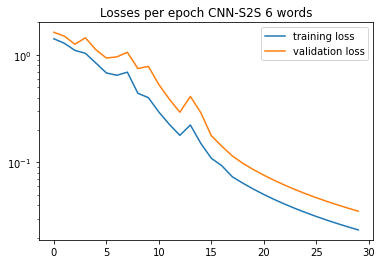

In [34]:
plt.yscale("log")
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.title('Losses per epoch CNN-S2S 6 words')
plt.legend();
plt.savefig('6 words losses log lr 0,001')

In [32]:
# EVALUATING THE MODEL:

import time
start_time = time.time()

# Setting the image parameters:

height = 48
width = 192

# Setting the sliding window parameters:

patch_height = 48
patch_width = 10 
stepsize = 2
n_patches = int((width - patch_width)/2 + 1)

input_word_test = 'victoria'

torch.manual_seed(123)

image_test = 255 * np.ones(shape=[height, width], dtype=np.uint8)
image_test = cv2.putText(image_test, text = input_word_test, org=(5, 30),
fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, color=(0,0,0),
thickness=2, lineType=cv2.LINE_AA)

image_test = transforms.ToPILImage()(image_test) # np.ndarray to PIL.Image.Image

input_word_test = list(input_word_test)
input_word_test_length = len(input_word_test) # number of letters


with torch.no_grad():
    
    encoder_hidden_test = Encoder_model.initHidden()

    for p in range(n_patches):

        patch_test = transforms.functional.crop(image_test, 0, 0 + p * stepsize, patch_height, patch_width) # cropping of the image into patches
        patch_test = transforms.ToTensor()(patch_test) # torch.Tensor of the patch (normalized)
        #patch_test = skimage.util.random_noise(patch_test, mode='gaussian')
        #patch_test = torch.from_numpy(patch_test)
        patch_test = 1. - patch_test
        patch_test = patch_test.view(1, 1, 48, 10) # CNN_model expects a 4-dimensional tensor (1 dimension for batch)
        patch_test = patch_test.type(torch.FloatTensor)
        patch_test = patch_test.cuda()

        encoder_input_test = CNN_model(patch_test).cuda() # 1024-length vector associated to patch p (i.e. CNN output, Encoder input)

        _, encoder_hidden_test = Encoder_model(encoder_input_test, encoder_hidden_test)

    decoder_input_test = letter_to_vector('SOS_token').cuda()
    decoder_hidden_test = encoder_hidden_test


    for d in range(input_word_test_length):

        decoder_output_test, decoder_hidden_test = Decoder_model(decoder_input_test, decoder_hidden_test)
        #decoder_input = letter_to_vector(input_word[d])

        one_hot_decoder_output_test = torch.zeros(1, 1, output_size).cuda()
        one_hot_decoder_output_test[0][0][torch.argmax(decoder_output_test)] = 1.
        decoder_input_test = one_hot_decoder_output_test.cuda()

        if torch.equal(one_hot_decoder_output_test, letter_to_vector('EOS_token').cuda())==True:
            break

        if d == 0:

            output_word_test = decoder_output_test
            one_hot_input_letter_test = letter_to_vector(input_word_test[d]).type(torch.LongTensor)
            one_hot_input_word_test = one_hot_input_letter_test
            index_test = torch.argmax(one_hot_input_letter_test.view(output_size))
            ground_letter_test = torch.tensor([index_test], dtype = torch.long)
            ground_word_test = ground_letter_test


        else:

            output_word_test = torch.cat((output_word_test, decoder_output_test), dim = 0) # we concatenate the remaining output letters
            one_hot_input_letter_test = letter_to_vector(input_word_test[d]).type(torch.LongTensor)
            one_hot_input_word_test = torch.cat((one_hot_input_word_test, one_hot_input_letter_test), dim = 0)
            index_test = torch.argmax(one_hot_input_letter_test.view(output_size))
            ground_letter_test = torch.tensor([index_test], dtype = torch.long)
            ground_word_test = torch.cat((ground_word_test, ground_letter_test), dim = 0)


    one_hot_input_word_test = one_hot_input_word_test.view(-1, output_size)
    output_word_test = output_word_test.view(-1, output_size) 
    ground_word_test = ground_word_test.cuda()


model_word = []

indices = torch.argmax(output_word_test, dim = 1)
for i in range(indices.numel()):
    model_word.append(letters[indices[i]])

model_word = ''.join(model_word)    
print(model_word)

        
print(f'Duration: {(time.time() - start_time)/60} minutes')

victoria
Duration: 0.0017043749491373699 minutes


In [33]:
torch.save(CNN_model.state_dict(), 'CNN_model_6_words.pt')
torch.save(Encoder_model.state_dict(), 'Encoder_model_6_words.pt')
torch.save(Decoder_model.state_dict(), 'Decoder_model_6_words.pt')